     cost                               request   time  billed_time  memory  \
0     2.0  abfeb743-e977-4194-8d8b-a8b9082f8774  61.35           62     128   
1     2.0  3e28bf0f-68a2-4135-b164-b938f017e893  24.43           25     128   
2     2.0  60ed3eb3-2550-479f-85ef-956d219c2ad8  23.19           24     128   
3     2.0  5021fc63-8336-4e6c-9e4e-1c643866411b  42.67           43     128   
4     2.0  6072225a-87e1-459e-af99-a97b29bd5b08  41.23           42     128   
..    ...                                   ...    ...          ...     ...   
643   2.0  a666878b-fe1e-49f0-a56e-e9f37d3cdb54  25.10           26    2048   
644   2.0  753d5023-9e11-410a-8f8a-1b4331102bba  34.80           35    2048   
645   2.0  4c98c8a2-e070-434d-a761-cd6f04ff1b93  26.65           27    2048   
646   2.0  876bb363-3a16-4c83-b273-82ad4b648d7e  61.28           62    2048   
647   2.0  208b6aae-6bbd-41e4-abd4-1fdf5af0192f  28.18           29    2048   

     used_memory  clients  compute_cost  database_c

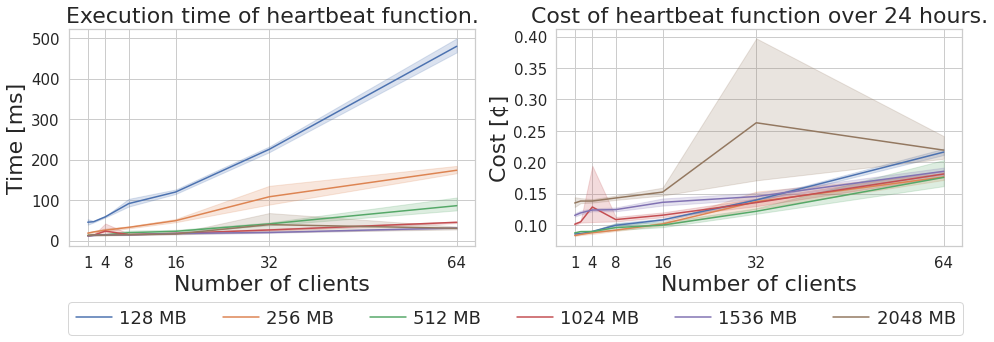

In [43]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats
from os.path import join, pardir

DATA_DIR = join(pardir, pardir, 'data', 'heartbeat')

sns.set(rc={'figure.figsize':(16,4)})
sns.set_style("whitegrid")

fig, axes = plt.subplots(ncols=2)
plt.subplots_adjust(wspace=0.2)

# DynamoDB
clients = [1, 2, 4, 8, 16, 32, 64]
dfs = []
for c in clients:
    data = pd.read_csv(join(DATA_DIR, f'benchmark_processed_{c}.csv'), index_col=0)
    data['clients'] = c
    #print(data)
    dfs.append(data)
df = pd.concat(dfs)

# cost (per day)
requests = 60*24
request_cost = 0.20 / 10**6
# per mb-second
duration_cost = 0.0000166667
# dynamodb cost
dynamodb_r_cost = 0.25 / 10**6

df['compute_cost'] = df['billed_time'] * df['memory'] * (duration_cost / 1000) / 1024.0
df['database_cost'] = df['cost'] * dynamodb_r_cost
# convert to cents
df['total_cost'] = df['compute_cost'] * requests + df['database_cost'] * requests
df['total_cost'] *= 100
print(df)

sns.lineplot(data=df, x='clients', y='time', hue='memory', ax=axes[0], palette=["C0", "C1", "C2", "C3", "C4", "C5"])#,fontsize=20)
#sns.lineplot(data=persistent.loc[persistent['op'] == 'write'], x='size', y='data', ax=axes[0], label='S3')#,fontsize=20)
#axes[0].legend(fontsize=20)
sns.lineplot(data=df, x='clients', y='total_cost', hue='memory', ax=axes[1], palette=["C0", "C1", "C2", "C3", "C4", "C5"])#,fontsize=20)


locs = [2 ** i for i in range(0, 8)]
del locs[1]
axes[0].xaxis.set_major_locator(ticker.FixedLocator(locs))
axes[1].xaxis.set_major_locator(ticker.FixedLocator(locs))
#axes[0].xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
#axes[0].set_ylim(0, 410)
#axes[0].set_yscale('log')
#axes[1].set_ylim(0, 410)
axes[0].set_xlabel('Number of clients',fontsize=22)
axes[1].set_xlabel('Number of clients',fontsize=22)
axes[0].set_ylabel('Time [ms]',fontsize=22)
axes[1].set_ylabel('Cost [¢]',fontsize=22)
axes[0].set_title('Execution time of heartbeat function.', fontsize=22)
axes[1].set_title('Cost of heartbeat function over 24 hours.', fontsize=22)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

#axes[1].annotate('Penalty on cross\nregion access.', xy=(300, 210),
#            xytext=(200, 80), fontsize=20, fontweight='bold',
#            arrowprops=dict(facecolor='black', shrink=0.05)
#)
#axes[1].annotate('', xy=(300, 30),
#            xytext=(300, 80), fontsize=20, fontweight='bold',
#            arrowprops=dict(facecolor='black', shrink=0.05)
#)
#axes[1].annotate('Slow writes on large\n(user) data.', xy=(300, 300),
#            xytext=(0, 230), fontsize=20, fontweight='bold',
#            arrowprops=dict(facecolor='black', shrink=0.05)
#)

#axes[0].annotate('Penalty on cross region access.', xy=(490, 380),
#            xytext=(0, 300), fontsize=20, fontweight='bold',
#            arrowprops=dict(facecolor='black', shrink=0.05),
#            #ha='left'
#)
#axes[0].annotate('Efficient read and write\non large user data.', xy=(400, 100),
#            xytext=(150, 125), fontsize=20, fontweight='bold',
#            arrowprops=dict(facecolor='black', shrink=0.05)
#)

axes[0].legend().set_visible(False)
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles, [f"{m} MB" for m in labels], ncol=6, bbox_to_anchor=(-0.10, -0.45), loc='lower center', handletextpad=0.4, fontsize=18)


#ax.set_title('1M read (solid) and\nwrite (dotted) operations.', fontsize=22)
#axes[0].plot(,yrange,color='green',linestyle='solid', label='AWS S3', linewidth=4)

plt.savefig("performance_plot.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)